# Normalise Tyre Performance

The goal of this analysis is to identify coefficients which would allow us to determine the impact of different
tyre compounds (Softs, Mediums, Hards) on lap times.

The idea is for the analysis to be conducted in two ways:
1. General coefficients - applied across all drivers
2. Driver-specific coefficients - applied specifically to each driver, on top of general coefficients

In [1]:
import sys
import fastf1
import fastf1.plotting
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge

sys.path.append("../..")
from common import Config, _logger

pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)

In [2]:
fastf1.plotting.setup_mpl()
fastf1.Cache.enable_cache(Config.FASTF1_CACHE_DIR)
fastf1.set_log_level('ERROR')

## Settings & Parameters

In [3]:
YEAR = 2024
TRACK = 'Bahrain'
LAPTIME_PERCENTILE_THRESHOLD = 0.75

## Load Session Data

In [4]:
laps_df = []
weather_df = []
telemetry_df = []
for session_type in ['FP1', 'FP2', 'FP3']:
    session = fastf1.get_session(YEAR, TRACK, session_type)
    session.load()
    append_df = session.laps.assign(Session=session_type)
    laps_df.append(append_df)
    for driver in append_df['Driver'].sort_values().unique():
        telemetry_df.append(session.laps.pick_driver(driver).get_telemetry().assign(Driver=driver, Session=session_type))
    append_df = session.laps.get_weather_data().drop_duplicates().sort_values(by='Time').reset_index(drop=True)\
        .assign(Session=session_type)
    weather_df.append(append_df)
laps_df = pd.concat(laps_df, axis=0).reset_index(drop=True)
weather_df = pd.concat(weather_df, axis=0).reset_index(drop=True)
weather_df['WeatherTimeId'] = weather_df.index
telemetry_df = pd.concat(telemetry_df, axis=0).reset_index(drop=True)

circuit_info = session.get_circuit_info()

In [5]:
# Extracting lap information and adding weather
valid_laps_df = laps_df.query("(Deleted == False) and (IsAccurate == True)").copy()
valid_laps_df['LapTime_seconds'] = valid_laps_df['LapTime'].dt.total_seconds()
_valid_laps_df = []
for session_type in valid_laps_df['Session'].sort_values().unique():
    session_weather_df = weather_df.query(f"Session == '{session_type}'")
    append_df = valid_laps_df.query(f"Session == '{session_type}'").copy()
    append_df['WeatherTimeId'] = pd.cut(
        append_df['Time'],
        bins=session_weather_df['Time'].tolist() + [session_weather_df['Time'].max() + timedelta(days=1)],
        labels=session_weather_df['WeatherTimeId'].tolist(),
        include_lowest=True,
    )
    _valid_laps_df.append(append_df)
valid_laps_df = pd.concat(_valid_laps_df, axis=0).reset_index(drop=True)
valid_laps_df = valid_laps_df.merge(weather_df.drop(columns=['Time']), on=['Session', 'WeatherTimeId'], how='left')\
    .drop(columns=['WeatherTimeId'])
valid_laps_df = valid_laps_df.query("(Rainfall == False)").copy()
valid_laps_df = valid_laps_df.query(f"LapTime_seconds < {valid_laps_df['LapTime_seconds'].quantile(LAPTIME_PERCENTILE_THRESHOLD)}").copy()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


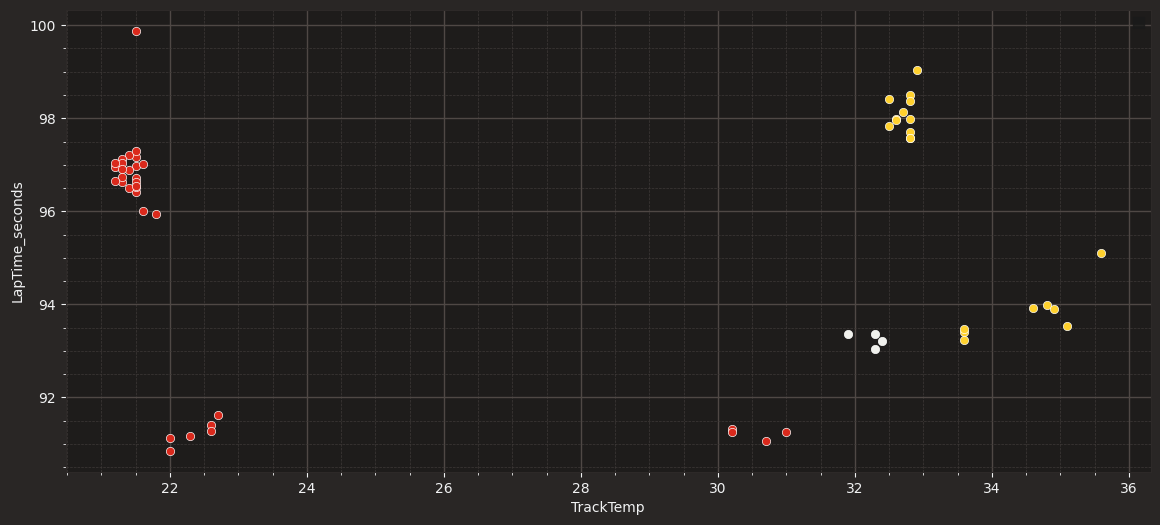

In [6]:
team = 'Red Bull Racing'

fig, ax = plt.subplots(figsize=(14, 6))
team_df = valid_laps_df.query(f"Team == '{team}' and LapTime_seconds < 100")
for driver in team_df['Driver'].sort_values().unique():
    driver_df = team_df.query(f"Driver == '{driver}'")
    for session_type in driver_df['Session'].sort_values().unique():
        session_driver_df = driver_df.query(f"Session == '{session_type}'")
        for stint in session_driver_df['Stint'].sort_values().unique():
            plot_df = session_driver_df.query(f"Stint == {stint}")
            compound = plot_df['Compound'].values[0]
            sns.scatterplot(
                data=plot_df, x='TrackTemp', y='LapTime_seconds', ax=ax, 
                # label=f"[{driver}] [{session_type}] Stint #{stint:.0f} ({compound})", 
                label='__nolegend__',
                color=fastf1.plotting.COMPOUND_COLORS[compound]
            )
ax.legend()

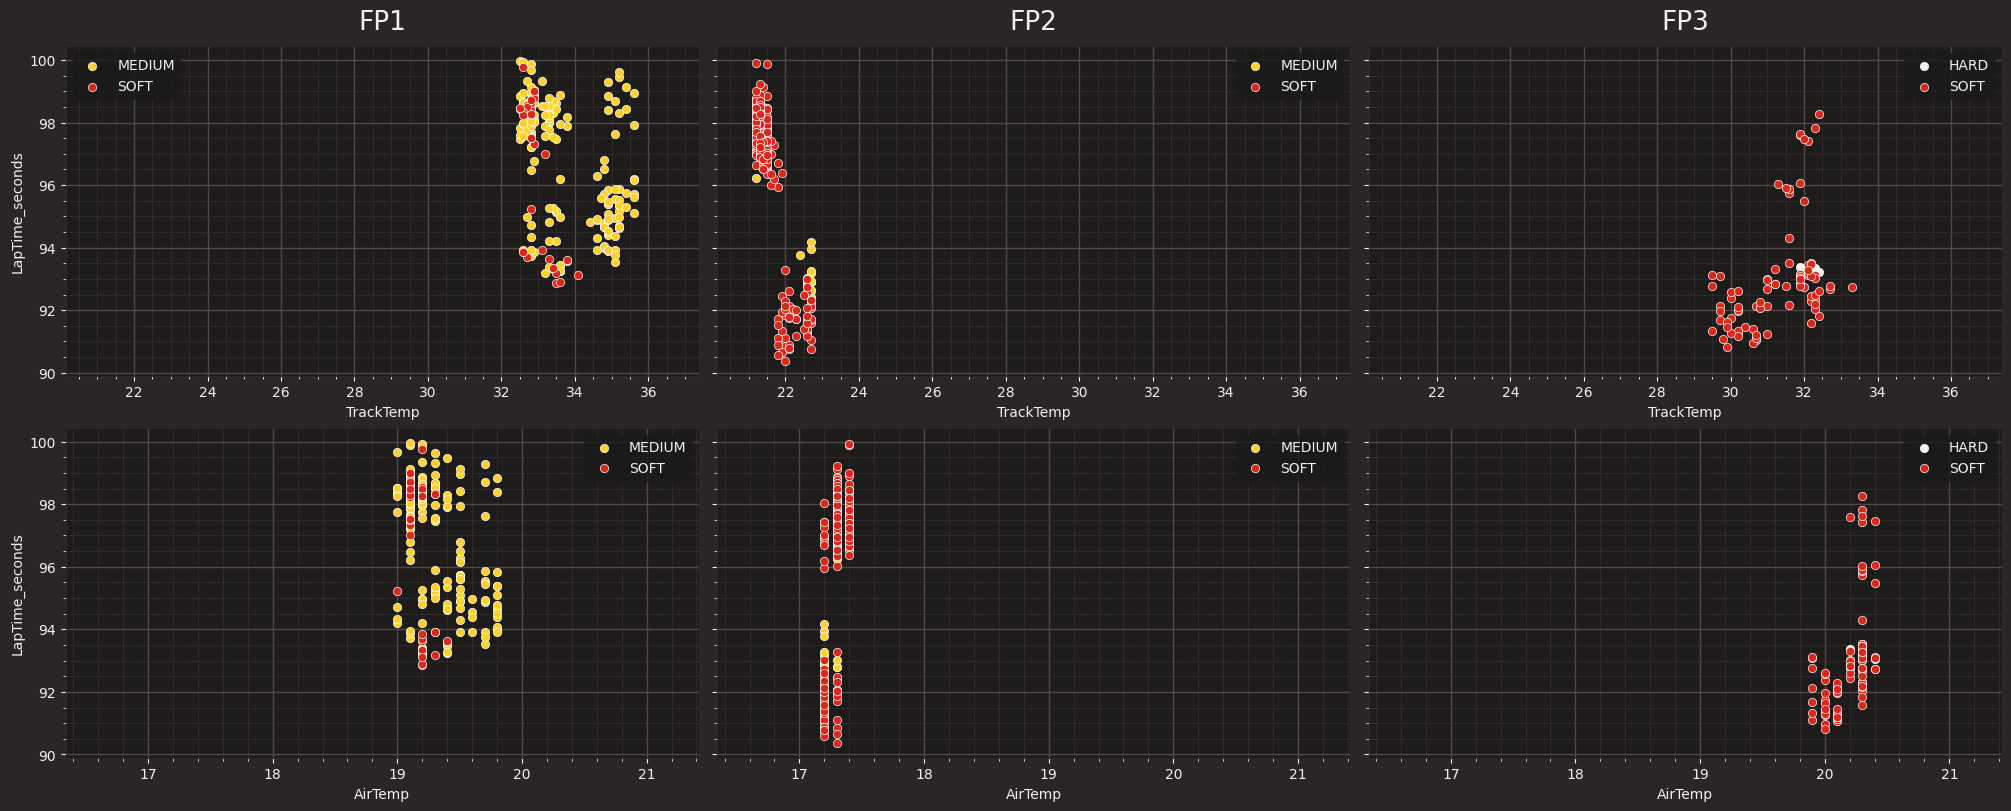

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8), constrained_layout=True, sharey=True)
for col_id, session_type in enumerate(valid_laps_df['Session'].sort_values().unique()):
    session_df = valid_laps_df.query(f"Session == '{session_type}'")
    for compound in session_df['Compound'].sort_values().unique():
        plot_df = session_df.query(f"Compound == '{compound}' and LapTime_seconds < 100")
        sns.scatterplot(
            data=plot_df, x='TrackTemp', y='LapTime_seconds', ax=axes[0][col_id], 
            label=compound, color=fastf1.plotting.COMPOUND_COLORS[compound]
        )
        sns.scatterplot(
            data=plot_df, x='AirTemp', y='LapTime_seconds', ax=axes[1][col_id], 
            label=compound, color=fastf1.plotting.COMPOUND_COLORS[compound]
        )
    axes[0][col_id].set_title(session_type)
    axes[0][col_id].set_xlim(valid_laps_df['TrackTemp'].min() * 0.95, valid_laps_df['TrackTemp'].max() * 1.05)
    axes[1][col_id].set_xlim(valid_laps_df['AirTemp'].min() * 0.95, valid_laps_df['AirTemp'].max() * 1.05)

## Regression Fitting

In [8]:
# One-hot encoding
valid_laps_df = valid_laps_df.drop(columns=[x for x in valid_laps_df.columns if x.startswith('Team_')])
valid_laps_df = valid_laps_df.drop(columns=[x for x in valid_laps_df.columns if x.startswith('Driver_')])
valid_laps_df = valid_laps_df.drop(columns=[x for x in valid_laps_df.columns if x.startswith('Compound_')])
valid_laps_df = pd.concat([valid_laps_df, pd.get_dummies(valid_laps_df['Team'], prefix='Team')], axis=1)
valid_laps_df = pd.concat([valid_laps_df, pd.get_dummies(valid_laps_df['Driver'], prefix='Driver')], axis=1)
valid_laps_df = pd.concat([valid_laps_df, pd.get_dummies(valid_laps_df['Compound'], prefix='Compound')], axis=1)

# Split TyreLife based on Compounds
valid_laps_df['TyreLife_SOFT'] = np.where(valid_laps_df['Compound'] == 'SOFT', valid_laps_df['TyreLife'], 0)
valid_laps_df['TyreLife_MEDIUM'] = np.where(valid_laps_df['Compound'] == 'MEDIUM', valid_laps_df['TyreLife'], 0)
valid_laps_df['TyreLife_HARD'] = np.where(valid_laps_df['Compound'] == 'HARD', valid_laps_df['TyreLife'], 0)

# Lap Number within Stint
valid_laps_df = valid_laps_df.sort_values(by=['Session', 'Driver', 'Stint', 'LapNumber'])
valid_laps_df['LapNumberWithinStint'] = valid_laps_df.groupby(['Session', 'Driver', 'Stint']).cumcount() + 1

# Normalisation
for feature in ['TyreLife_SOFT', 'TyreLife_MEDIUM', 'TyreLife_HARD', 'LapNumber', 'LapNumberWithinStint']:
    if valid_laps_df[feature].nunique() == 1:
        valid_laps_df[f'{feature}_Normalised'] = 0
    else:
        valid_laps_df[f'{feature}_Normalised'] = valid_laps_df[feature] / valid_laps_df[feature].max()

In [9]:
# Adding DRS Information to valid_laps_df
telemetry_df = telemetry_df.drop(columns=[x for x in telemetry_df.columns if x in ['LapNumber']])
_telemetry_df = []
for driver in telemetry_df['Driver'].sort_values().unique():
    driver_telemetry_df = telemetry_df.query(f"Driver == '{driver}'").copy()
    for session in telemetry_df['Session'].sort_values().unique():
        driver_session_telemetry_df = driver_telemetry_df.query(f"Session == '{session}'").copy()
        driver_session_laps_df = laps_df.query(f"Driver == '{driver}' and Session == '{session}'")
        driver_session_telemetry_df['LapNumber'] = pd.cut(
            driver_session_telemetry_df['Time'],
            bins=driver_session_laps_df['Time'].tolist() + [driver_session_laps_df['Time'].max() + timedelta(days=1)],
            labels=driver_session_laps_df['LapNumber'].tolist(),
            include_lowest=True,
        )
        _telemetry_df.append(driver_session_telemetry_df)
telemetry_df = pd.concat(_telemetry_df, axis=0).reset_index(drop=True)
telemetry_df['DRS_Enabled'] = np.where(telemetry_df['DRS'].isin([10, 12, 14]), 1, 0)

lap_drs_df = telemetry_df.groupby(['Driver', 'Session', 'LapNumber']).agg({'DRS_Enabled': 'max'}).reset_index()
valid_laps_df = valid_laps_df.drop(columns=[x for x in valid_laps_df.columns if x in ['DRS_Enabled']])\
    .merge(lap_drs_df, on=['Driver', 'Session', 'LapNumber'], how='left')
valid_laps_df['DRS_Enabled'] = valid_laps_df['DRS_Enabled'].fillna(0)

In [10]:
valid_laps_df.groupby(["Session", "Driver"]).agg({"LapTime_seconds": "min"}).sort_values(by=["Session", "LapTime_seconds"], ascending=[True, True])

LapTime_seconds
Session Driver                 
FP1     RIC              92.869
        NOR              92.901
        PIA              93.113
        TSU              93.183
        ALO              93.193
        VER              93.238
        RUS              93.251
        LEC              93.268
        HAM              93.302
        BOT              93.354
        SAI              93.385
        PER              93.413
        ALB              93.583
        STR              93.868
        ZHO              93.923
        SAR              94.213
        OCO              94.807
        GAS              95.144
        MAG              97.477
        HUL              97.938
FP2     HAM              90.374
        RUS              90.580
        ALO              90.660
        SAI              90.769
        PIA              90.784
        VER              90.851
        HUL              90.884
        STR              90.891
        LEC              91.113
        PER              91.115
        ALB              91.333
        RIC              91.516
        SAR              91.715
        MAG              91.764
        TSU              91.881
        GAS              91.951
        BOT              92.001
        OCO              92.027
        ZHO              92.048
        NOR              92.608
FP3     SAI              90.824
        ALO              90.965
        VER              91.062
        LEC              91.094
        NOR              91.118
        RUS              91.190
        PIA              91.210
        PER              91.248
        HUL              91.278
        STR              91.396
        RIC              91.449
        HAM              91.452
        TSU              91.631
        MAG              91.671
        ALB              91.965
        ZHO              92.000
        BOT              92.096
        OCO              92.124
        SAR              92.125
        GAS              92.382

2024-03-16 23:17:16,597 | DEBUG    | (1606090737.py:28) <module> - Intercept: 93.195
2024-03-16 23:17:16,602 | DEBUG    | (1606090737.py:29) <module> - Coefficients: 
                       coef  abs_coef
Compound_SOFT        -1.694     1.694
Compound_MEDIUM       0.927     0.927
Driver_HUL            0.882     0.882
Team_Haas F1 Team     0.868     0.868
DRS_Enabled          -0.862     0.862
Compound_HARD         0.768     0.768
TyreLife_SOFT         0.646     0.646
Driver_BOT           -0.542     0.542
Team_Ferrari         -0.513     0.513
TyreLife_MEDIUM       0.499     0.499
Driver_HAM            0.492     0.492
Driver_ZHO            0.426     0.426
Driver_LEC           -0.393     0.393
Team_Williams        -0.337     0.337
LapNumberWithinStint -0.301     0.301
Driver_NOR            0.297     0.297
Driver_RUS           -0.250     0.250
Driver_ALO           -0.247     0.247
Team_Mercedes         0.242     0.242
Driver_SAR           -0.234     0.234
Team_Aston Martin    -0.222     0.2

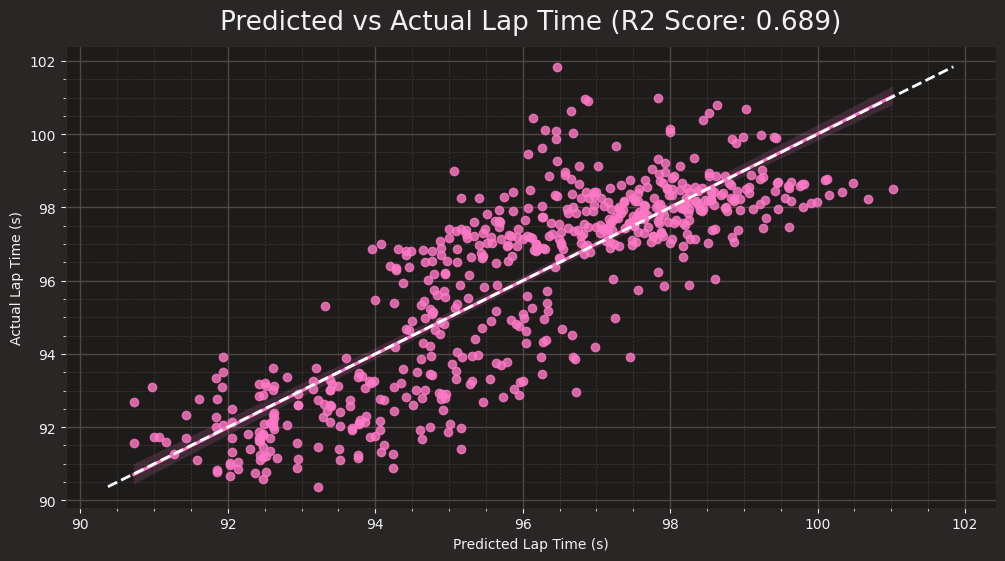

In [18]:
# Fitting linear regression and get coefficients
input_features = ['TyreLife_SOFT', 'TyreLife_MEDIUM', 'TyreLife_HARD', 'LapNumberWithinStint', 'DRS_Enabled'] + \
    [x for x in valid_laps_df.columns if x.startswith('Team_')] + \
    [x for x in valid_laps_df.columns if x.startswith('Driver_')] + \
    [x for x in valid_laps_df.columns if x.startswith('Compound_')]

# Fit a linear regression model
lr_model = Ridge()
lr_model = lr_model.fit(valid_laps_df[input_features], valid_laps_df['LapTime_seconds'])

# Extracting coefficients and intercept
coefficients, intercept = lr_model.coef_, lr_model.intercept_
coefficients = {k: v for k, v in zip(lr_model.feature_names_in_, coefficients)}
coefficients_df = pd.DataFrame.from_dict(coefficients, orient='index').rename(columns={0: 'coef'})\
    .assign(abs_coef=lambda x: x['coef'].abs())\
    .sort_values('abs_coef', ascending=False)

# Model R2 Score
y_true, y_pred = valid_laps_df['LapTime_seconds'], lr_model.predict(valid_laps_df[input_features])
r2_value = r2_score(y_true=valid_laps_df['LapTime_seconds'], y_pred=y_pred)
fig, ax = plt.subplots(figsize=(12, 6))
sns.regplot(x=y_pred, y=y_true, ax=ax)
ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--', lw=2, color='white')
ax.set_xlabel('Predicted Lap Time (s)')
ax.set_ylabel('Actual Lap Time (s)')
ax.set_title(f"Predicted vs Actual Lap Time (R2 Score: {r2_value:.3f})")

_logger.debug(f"Intercept: {intercept:.3f}")
_logger.debug(f"Coefficients: \n{coefficients_df.round(3)}")

## Comparison against Race Pace

In [12]:
session = fastf1.get_session(YEAR, TRACK, 'R')
session.load()

In [13]:
race_laps_df = session.laps.assign(Session='R')
race_weather_df = session.laps.get_weather_data().drop_duplicates().sort_values(by='Time').reset_index(drop=True)\
    .assign(Session='R')
race_weather_df['WeatherTimeId'] = race_weather_df.index

In [14]:
valid_race_laps_df = race_laps_df.query("(Deleted == False) and (IsAccurate == True)").copy()
valid_race_laps_df['LapTime_seconds'] = valid_race_laps_df['LapTime'].dt.total_seconds()
valid_race_laps_df['WeatherTimeId'] = pd.cut(
    valid_race_laps_df['Time'],
    bins=race_weather_df['Time'].tolist() + [race_weather_df['Time'].max() + timedelta(days=1)],
    labels=race_weather_df['WeatherTimeId'].tolist(),
    include_lowest=True,
)
valid_race_laps_df = valid_race_laps_df.merge(race_weather_df.drop(columns=['Time']), on=['Session', 'WeatherTimeId'], how='left')\
    .drop(columns=['WeatherTimeId'])
valid_race_laps_df = valid_race_laps_df.query("(Rainfall == False)").copy()
valid_race_laps_df = valid_race_laps_df.query("LapTime_seconds < 100")

In [15]:
# One-hot encoding
valid_race_laps_df = valid_race_laps_df.drop(columns=[x for x in valid_race_laps_df.columns if x.startswith('Team_')])
valid_race_laps_df = valid_race_laps_df.drop(columns=[x for x in valid_race_laps_df.columns if x.startswith('Driver_')])
valid_race_laps_df = valid_race_laps_df.drop(columns=[x for x in valid_race_laps_df.columns if x.startswith('Compound_')])
valid_race_laps_df = pd.concat([valid_race_laps_df, pd.get_dummies(valid_race_laps_df['Team'], prefix='Team')], axis=1)
valid_race_laps_df = pd.concat([valid_race_laps_df, pd.get_dummies(valid_race_laps_df['Driver'], prefix='Driver')], axis=1)
valid_race_laps_df = pd.concat([valid_race_laps_df, pd.get_dummies(valid_race_laps_df['Compound'], prefix='Compound')], axis=1)

# Split TyreLife based on Compounds
valid_race_laps_df['TyreLife_SOFT'] = np.where(valid_race_laps_df['Compound'] == 'SOFT', valid_race_laps_df['TyreLife'], 0)
valid_race_laps_df['TyreLife_MEDIUM'] = np.where(valid_race_laps_df['Compound'] == 'MEDIUM', valid_race_laps_df['TyreLife'], 0)
valid_race_laps_df['TyreLife_HARD'] = np.where(valid_race_laps_df['Compound'] == 'HARD', valid_race_laps_df['TyreLife'], 0)

# Lap Number within Stint
valid_race_laps_df = valid_race_laps_df.sort_values(by=['Session', 'Driver', 'Stint', 'LapNumber'])
valid_race_laps_df['LapNumberWithinStint'] = valid_race_laps_df.groupby(['Session', 'Driver', 'Stint']).cumcount() + 1

# Normalisation
for feature in ['TyreLife_SOFT', 'TyreLife_MEDIUM', 'TyreLife_HARD', 'LapNumber', 'LapNumberWithinStint']:
    if valid_race_laps_df[feature].nunique() == 1:
        valid_race_laps_df[f'{feature}_Normalised'] = 0
    else:
        valid_race_laps_df[f'{feature}_Normalised'] = valid_race_laps_df[feature] / valid_race_laps_df[feature].max()

2024-03-16 23:13:59,724 | DEBUG    | (2250021271.py:29) <module> - Intercept: 97.761
2024-03-16 23:13:59,727 | DEBUG    | (2250021271.py:30) <module> - Coefficients: 
                       coef  abs_coef
Team_Red Bull Racing -0.772     0.772
Driver_VER           -0.567     0.567
Team_Alpine           0.507     0.507
Team_Ferrari         -0.470     0.470
Team_Williams         0.453     0.453
Team_Kick Sauber      0.395     0.395
Driver_BOT            0.373     0.373
Driver_MAG            0.368     0.368
Driver_SAI           -0.355     0.355
Driver_OCO            0.354     0.354
Team_RB               0.325     0.325
Team_Mercedes        -0.321     0.321
Team_McLaren         -0.293     0.293
Driver_TSU            0.286     0.286
Driver_SAR            0.240     0.240
Driver_HUL           -0.214     0.214
Driver_ALB            0.212     0.212
Driver_PER           -0.205     0.205
Driver_RUS           -0.194     0.194
Driver_NOR           -0.178     0.178
Team_Haas F1 Team     0.154     0.1

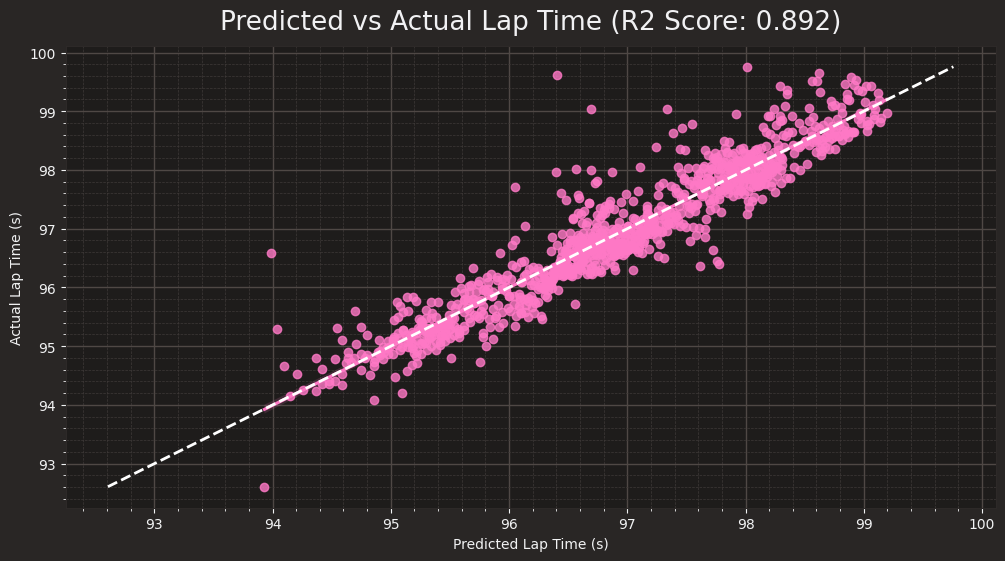

In [17]:
# Fitting linear regression and get coefficients
input_features = ['TyreLife_SOFT', 'TyreLife_MEDIUM', 'TyreLife_HARD', 'LapNumber', 'LapNumberWithinStint'] + \
    [x for x in valid_race_laps_df.columns if x.startswith('Team_')] + \
    [x for x in valid_race_laps_df.columns if x.startswith('Driver_')] + \
    [x for x in valid_race_laps_df.columns if x.startswith('Compound_')]

# Fit a linear regression model
lr_model = Ridge()  # Ridge is preferred over LinearRegression to avoid cases of exploding coefficients
lr_model = lr_model.fit(valid_race_laps_df[input_features], valid_race_laps_df['LapTime_seconds'])
model_not_fit = False

# Extracting coefficients and intercept
coefficients, intercept = lr_model.coef_, lr_model.intercept_
coefficients = {k: v for k, v in zip(lr_model.feature_names_in_, coefficients)}
coefficients_df = pd.DataFrame.from_dict(coefficients, orient='index').rename(columns={0: 'coef'})\
    .assign(abs_coef=lambda x: x['coef'].abs())\
    .sort_values('abs_coef', ascending=False)

# Model R2 Score
y_true, y_pred = valid_race_laps_df['LapTime_seconds'], lr_model.predict(valid_race_laps_df[input_features])
r2_value = r2_score(y_true=valid_race_laps_df['LapTime_seconds'], y_pred=y_pred)
fig, ax = plt.subplots(figsize=(12, 6))
sns.regplot(x=y_pred, y=y_true, ax=ax)
ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--', lw=2, color='white')
ax.set_xlabel('Predicted Lap Time (s)')
ax.set_ylabel('Actual Lap Time (s)')
ax.set_title(f"Predicted vs Actual Lap Time (R2 Score: {r2_value:.3f})")

_logger.debug(f"Intercept: {intercept:.3f}")
_logger.debug(f"Coefficients: \n{coefficients_df.round(3)}")